In [75]:
"""
use this notebook to make the secondary signal processing code (applying cuts to the data)

Cuts:



CSV has columns 0 to 12:
(index column)
column 0: baseline
column 1: sd_baseline
column 2: amplitude
column 3: peak_time
column 4: FWHM
column 5: t1_of_FWHM
column 6: t2_of_FWHM
column 7: time_above_3sigma
column 8: first_3sigma_crossing
column 9: second_3sigma_crossing
column 10: integral_pC
column 11: peaks_over_15sigma_threshold
column 12: event_timestamps

"""

'\nuse this notebook to make the secondary signal processing code (applying cuts to the data)\n\nCuts:\n\n\n\nCSV has columns 0 to 12:\n(index column)\ncolumn 0: baseline\ncolumn 1: sd_baseline\ncolumn 2: amplitude\ncolumn 3: peak_time\ncolumn 4: FWHM\ncolumn 5: t1_of_FWHM\ncolumn 6: t2_of_FWHM\ncolumn 7: time_above_3sigma\ncolumn 8: first_3sigma_crossing\ncolumn 9: second_3sigma_crossing\ncolumn 10: integral_pC\ncolumn 11: peaks_over_15sigma_threshold\ncolumn 12: event_timestamps\n\n'

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
import os
from os.path import exists
import matplotlib.colors as mcolors

#file being read in
df = pd.read_csv('PMT1_Processed/141125_darkrate_1950_10000_1_on_processed_threshold15.csv')
#df = pd.read_csv('Processed15Sigma/131125_darkrate_1800_10000_2_on_processed_threshold15.csv')

#file being outputted
cleaned_data_filename = 'DarkRateVaryingVProcessed/141125_darkrate_2000_10000_1_off_processed.csv'
folder_name = "DarkRateVaryingVClean"
file_path = os.path.join(os.getcwd(), folder_name, cleaned_data_filename)

#change based on needs/experiment
v_window_size = (-25e-3, 225e-3) #remember that the y-axis is flipped so pulse is positive
tolerance = 5e-4 #discard any events which come within 1mV of the window edge

#make data frame for cleaned data
cleaned_df = df.copy()

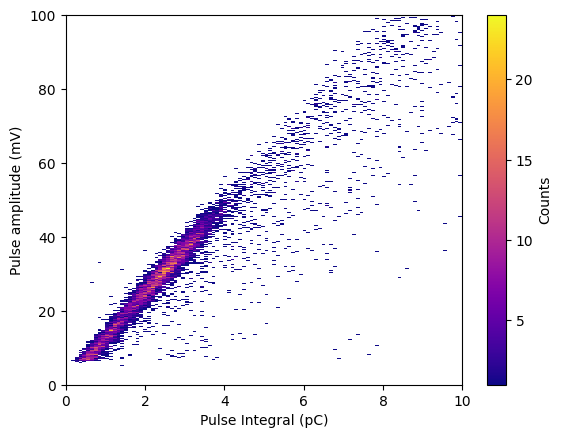

In [77]:
# plot 2d histogram of pulse amplitudes before cuts
amplitudes = df['amplitude'] * 1e3
pulse_integrals = df['integral_pC']

#plt.hist2d(pulse_integrals, amplitudes, bins=10, range=None, density=False)
h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',     # nicer color map
    cmin=1
    
)
plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 10])
plt.ylim([0, 100])
plt.show()

In [78]:
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 0
number of events in cleaned data frame: 10000


<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:207: SyntaxWarning: invalid escape sequence '\m'
<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:207: SyntaxWarning: invalid escape sequence '\m'
C:\Users\holly\AppData\Local\Temp\ipykernel_27716\4094200866.py:126: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold after cleaning (ns)')
C:\Users\holly\AppData\Local\Temp\ipykernel_27716\4094200866.py:207: SyntaxWarning: invalid escape sequence '\m'
  r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)


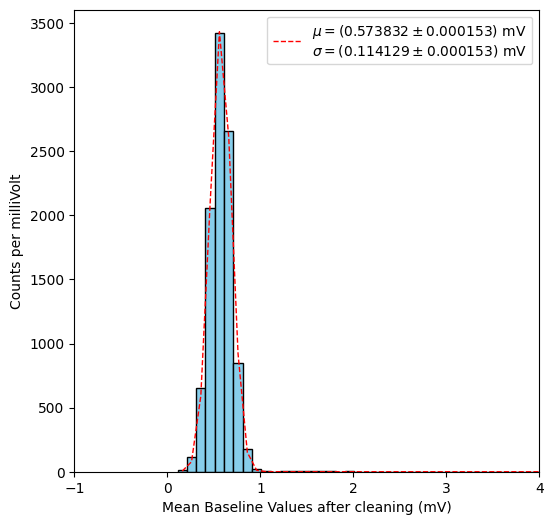

Fit completed max 3 iterations.


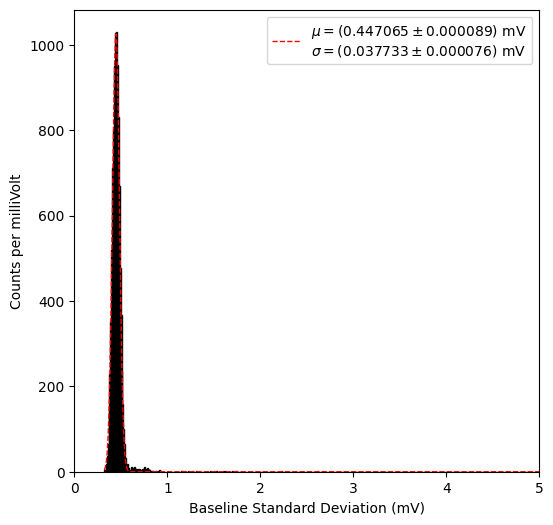

amount of events removed: 0
number of events in cleaned data frame: 10000


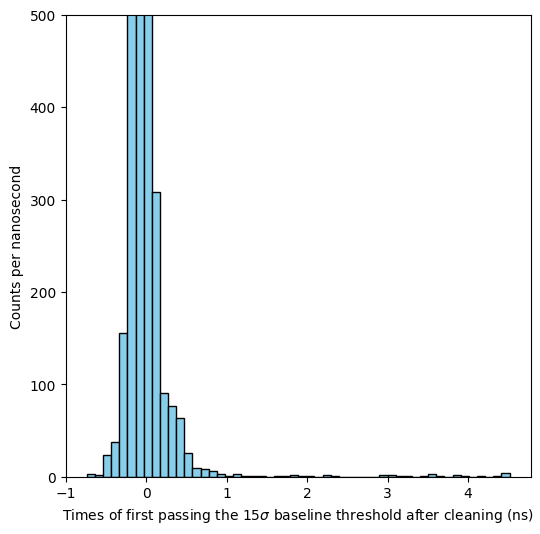

44.374819537516665


C:\Users\holly\AppData\Local\Temp\ipykernel_27716\4094200866.py:126: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold after cleaning (ns)')
C:\Users\holly\AppData\Local\Temp\ipykernel_27716\4094200866.py:207: SyntaxWarning: invalid escape sequence '\m'
  r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

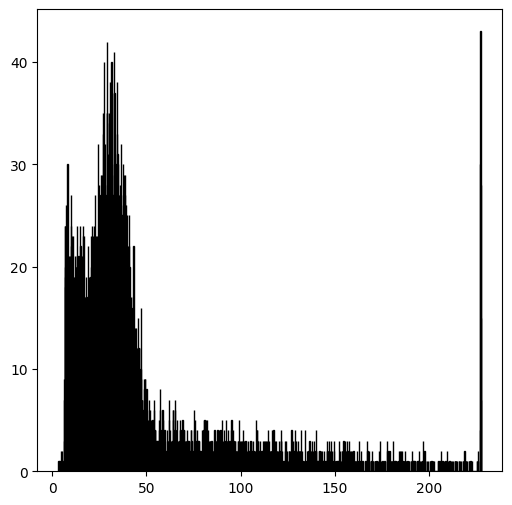

In [79]:
#cut data with large baseline noise (std>mu+15sigma)

#baseline mean and gaussian
plt.figure(figsize=(6,6))
mean_b_array_mV = df['baseline'].to_numpy() * 1e3 

def gaussian_mb(x, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (x - mu)**2)/ sigma**2)

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.1) #chosen 1 bin = 0.1 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(gaussian_mb, bin_centers, n, p0=[np.max(n), np.mean(mean_b_array_mV), np.std(mean_b_array_mV)])
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
mu_mb = popt[1]
sigma_mb = popt[2]
mb_fit = gaussian_mb(bin_centers, *popt)
plt.plot(bin_centers, mb_fit, 'r--', linewidth=1)
plt.xlim(-1, 4)
plt.xlabel('Mean Baseline Values after cleaning (mV)')
plt.ylabel('Counts per milliVolt')
plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_mb, err_mu, sigma_mb, err_sigma)], loc='best', fontsize=10)
plt.show()

# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))
sigma_b_array_mV = df['sd_baseline'].to_numpy() * 1e3

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.01) #chosen 1 bin = 0.01mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    mu_sb = final_popt[1]
    sigma_sb = final_popt[2]
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1)
    plt.xlim(0, 5)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_sb, err_mu, sigma_sb, err_sigma)], loc='best', fontsize=10)
    plt.show()

#print( mu_sb, sigma_sb)

#good_sigma = cleaned_df['sd_baseline'] < ((mu_sb +15*sigma_sb) * 1e-3)
#cleaned_df = cleaned_df[good_sigma]
#print(len(df) - len(cleaned_df))
#print(mu_sb + 15*sigma_sb)
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

plt.figure(figsize=(6, 6))
filtered_crossings_ns = df['first_threshold_crossing'].dropna().to_numpy() * 1e9
if len(filtered_crossings_ns) > 1:
    crosst_number_of_bins = int((np.max(filtered_crossings_ns) - np.min(filtered_crossings_ns)) / 0.1) #chosen 1 bin = 0.1ns
    plt.hist(filtered_crossings_ns, bins=crosst_number_of_bins, color='skyblue', edgecolor='black')
    #plt.xlim(-20,50)
    plt.ylim(0,500)
    plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold after cleaning (ns)')
    plt.ylabel('Counts per nanosecond')
    plt.show()
else:
    print("Cannot plot histogram: Fewer than two valid first crossing times found.")

# histogram for Peak Amplitudes
"""
plt.figure(figsize=(6, 6))
all_amplitudes_mV = df['amplitude'].to_numpy() * 1e3

def gaussian_amp(all_amplitudes_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_amplitudes_mV - mu)**2)/ sigma**2)

amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=15e-3) & (bin_centers <=75e-3)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_amp, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_amp(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    amp_full_fit = gaussian_amp(bin_centers, *final_popt)
    mu_amp = final_popt[1]
    sigma_amp = final_popt[2]
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, amp_full_fit, 'r--', linewidth=1)
   # plt.xlim(0, 5)
    plt.xlabel('Pulse Amplitude (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_amp, err_mu, sigma_amp, err_sigma)], loc='best', fontsize=10)
    plt.show()
"""

plt.figure(figsize=(6, 6))
all_amplitudes_mV = df['amplitude'].to_numpy() * 1e3
print(np.mean(all_amplitudes_mV))

def gaussian_amp(all_amplitudes_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_amplitudes_mV - mu)**2)/ sigma**2)

bm_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
n, bins, patches = plt.hist(all_amplitudes_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
fit_mask = (bin_centers >= 15) & (bin_centers <=30 )
X_fit = bin_centers[fit_mask]
Y_fit = n[fit_mask]
p0 = [np.max(Y_fit), np.mean(X_fit), np.std(X_fit)]
popt, pcov = curve_fit(gaussian_amp, X_fit, Y_fit, p0=p0)
mu_amp = popt[1]
sigma_amp = popt[2]
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
amp_fit = gaussian_amp(bin_centers, *popt)
plt.plot(bin_centers, amp_fit, 'r--', linewidth=1)
#plt.xlim([0,50])
plt.xlabel('Pulse Amplitude (mV)')
plt.ylabel('Counts per milliVolt')
plt.legend([r'$\mathrm{Fit:}\ \mu=%.6f,\ \sigma=%.6f$' % (popt[1], popt[2])])
plt.show()

#good_amps = cleaned_df['amplitude'] > ((mu_amp +2*sigma_amp) * 1e-3)
#cleaned_df = cleaned_df[good_amps]


In [ ]:
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 0
number of events in cleaned data frame: 10000


In [ ]:
#eliminate the data points between the tolerance and the window edge 

#within_window = cleaned_df["amplitude"] < (v_window_size[1] - tolerance) #good events are those below the window edge tolerance

#cleaned_df = cleaned_df[within_window] 
#windowing_effect = len(cleaned_df) - len(cleaned_df)
#print(windowing_effect)

In [ ]:
#print('amount of events removed:', len(df)-len(cleaned_df))
#print('number of events in cleaned data frame:', len(cleaned_df))

In [ ]:
#eliminate the data points which have more than 1 peak (or 0 peaks)

#one_peak_events = cleaned_df["peaks_over_15sigma_threshold"] == 1 #good events only have 1 peak

#cleaned_df = cleaned_df[one_peak_events]

# number of values rejected after windowing and taking out those with no or multiple peaks
#one_peak_effect = len(cleaned_df) - len(cleaned_df)
#print(one_peak_effect)
#print(len(cleaned_df))

In [ ]:
#print('amount of events removed:', len(df)-len(cleaned_df))
#print('number of events in cleaned data frame:', len(cleaned_df))

In [ ]:
"""
apply noise threshold from rate analysis: 15sigma
cut out any data which doesnt pass the 15sigma threshold
this is already done with the multiple peak threshold as cut out anything with 0 peaks (not passing 15sigma)
"""

'\napply noise threshold from rate analysis: 15sigma\ncut out any data which doesnt pass the 15sigma threshold\nthis is already done with the multiple peak threshold as cut out anything with 0 peaks (not passing 15sigma)\n'

In [ ]:
#discard those with first crossing greater than 2ns (multiple peaks which slip through previous cleaning)

#first_crossing = cleaned_df["first_15sigma_crossing"] < 2e-9 #good events have first crossing times less than t=2

#cleaned_df = cleaned_df[first_crossing]

sigma_thresh = cleaned_df["time_above_threshold"] > 0 # input only events that cross threshold

cleaned_df = cleaned_df[sigma_thresh]


#thresh_effect = len(cleaned_df) - len(cleaned_df)
#print(thresh_effect)
#N = len(cleaned_df)
#print(sigma_effect + windowing_effect + one_peak_effect + thresh_effect)
#print(f'Number of samples left = {N}')


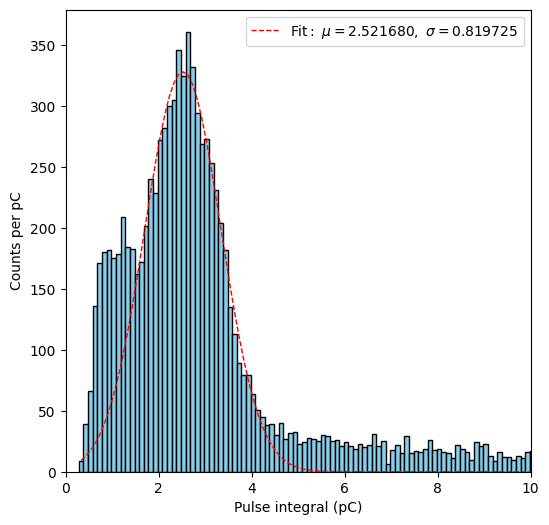

In [ ]:

plt.figure(figsize=(6, 6))
all_integrals_picocharge = cleaned_df['integral_pC'].to_numpy()


def gaussian_pulse(all_integrals_picocharge, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_integrals_picocharge - mu)**2)/ sigma**2)
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
fit_mask = (bin_centers >= 2) & (bin_centers <= 6)
X_fit = bin_centers[fit_mask]
Y_fit = n[fit_mask]
p0 = [np.max(Y_fit), np.mean(X_fit), np.std(X_fit)]
popt, pcov = curve_fit(gaussian_pulse, X_fit, Y_fit, p0=p0)
mu_amp = popt[1]
sigma_amp = popt[2]
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
pulse_fit = gaussian_pulse(bin_centers, *popt)
plt.plot(bin_centers, pulse_fit, 'r--', linewidth=1)
plt.xlim([0,10])
plt.xlabel('Pulse integral (pC)')
plt.ylabel('Counts per pC')
plt.legend([r'$\mathrm{Fit:}\ \mu=%.6f,\ \sigma=%.6f$' % (popt[1], popt[2])])
plt.show()

#good_int = cleaned_df['integral_pC'] > ((mu_amp - 2*sigma_amp))
#cleaned_df = cleaned_df[good_int]



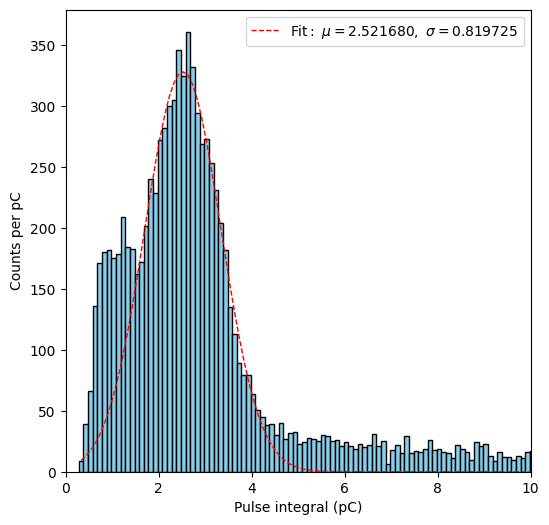

In [ ]:
plt.figure(figsize=(6, 6))
all_integrals_picocharge = cleaned_df['integral_pC'].to_numpy()


def gaussian_pulse(all_integrals_picocharge, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_integrals_picocharge - mu)**2)/ sigma**2)
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
fit_mask = (bin_centers >= 2) & (bin_centers <= 6)
X_fit = bin_centers[fit_mask]
Y_fit = n[fit_mask]
p0 = [np.max(Y_fit), np.mean(X_fit), np.std(X_fit)]
popt, pcov = curve_fit(gaussian_pulse, X_fit, Y_fit, p0=p0)
mu_amp = popt[1]
sigma_amp = popt[2]
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
pulse_fit = gaussian_pulse(bin_centers, *popt)
plt.plot(bin_centers, pulse_fit, 'r--', linewidth=1)
plt.xlim([0,10])
plt.xlabel('Pulse integral (pC)')
plt.ylabel('Counts per pC')
plt.legend([r'$\mathrm{Fit:}\ \mu=%.6f,\ \sigma=%.6f$' % (popt[1], popt[2])])
plt.show()

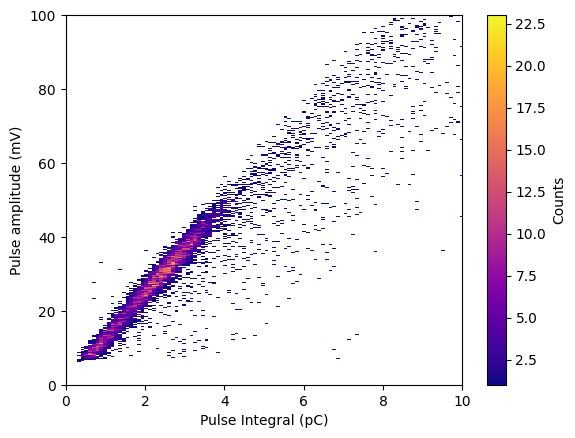

In [ ]:
amplitudes = cleaned_df['amplitude'] * 1e3
pulse_integrals = cleaned_df['integral_pC']

#plt.hist2d(pulse_integrals, amplitudes, bins=10, range=None, density=False)
h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',
    cmin=1,     # nicer color map
)
plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 10])
plt.ylim([0, 100])
#plt.ylim([np.min(amplitudes), 80])
plt.show()

In [ ]:
#print('amount of events removed:', len(df)-len(cleaned_df))
#print('number of events in cleaned data frame:', len(cleaned_df))

In [ ]:
#amplitude_cut = cleaned_df["amplitude"] > 20e-3
#cleaned_df = cleaned_df[amplitude_cut]

In [ ]:
#print('amount of events removed:', len(df)-len(cleaned_df))
#print('number of events in cleaned data frame:', len(cleaned_df))

<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:113: SyntaxWarning: invalid escape sequence '\s'
C:\Users\holly\AppData\Local\Temp\ipykernel_27716\2850719727.py:113: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold after cleaning (ns)')


1.9130653090643999
4.36232480445043 29.96354800215502


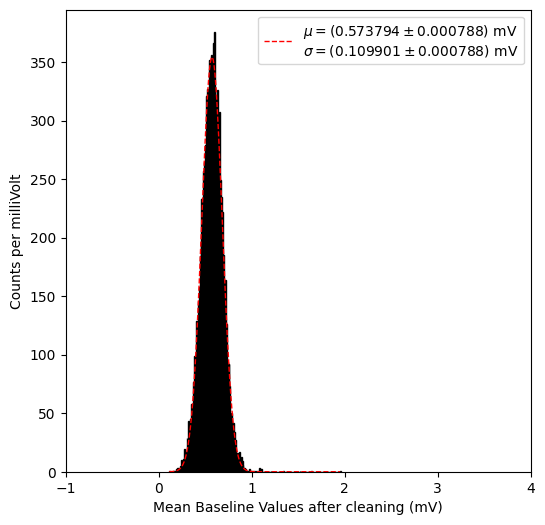

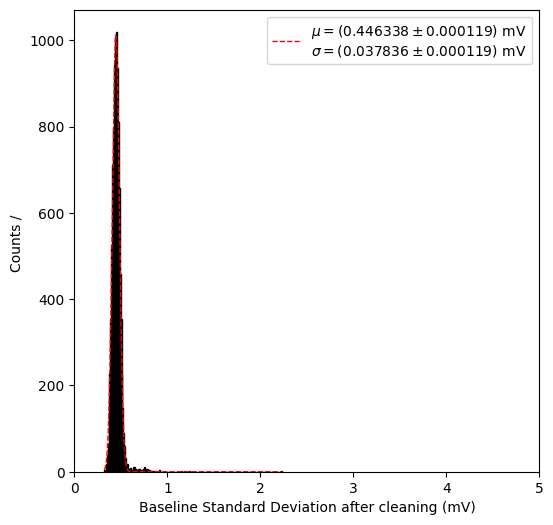

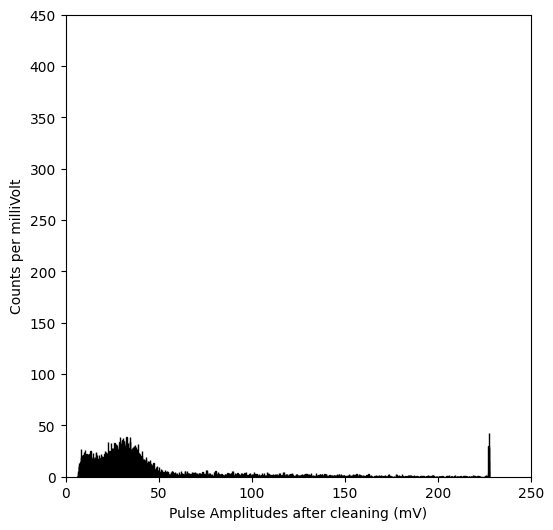

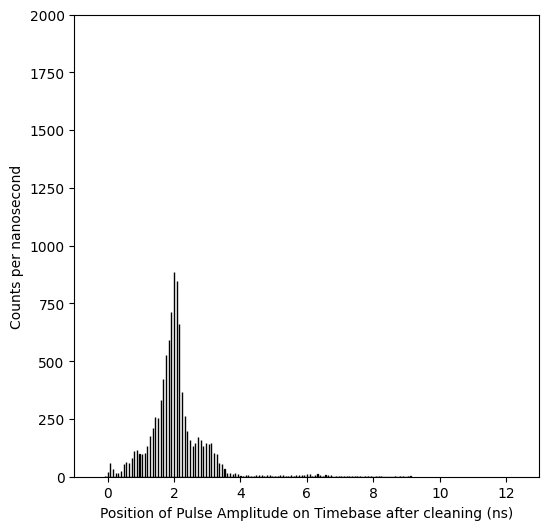

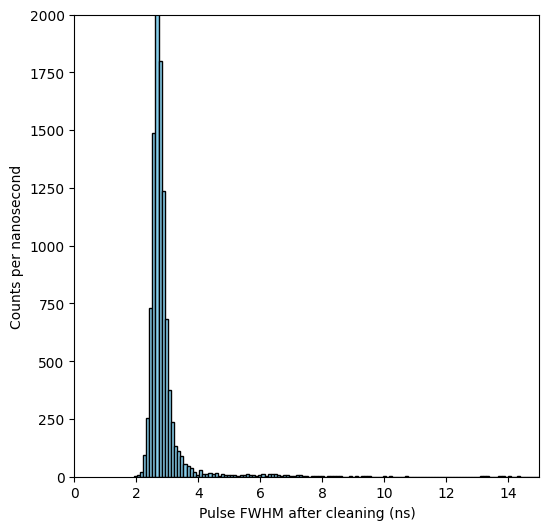

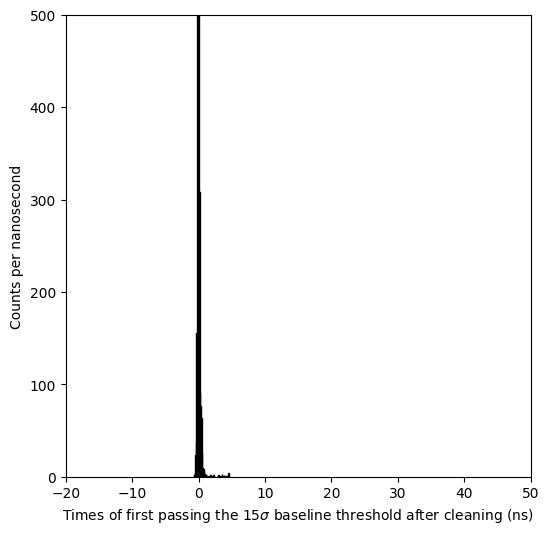

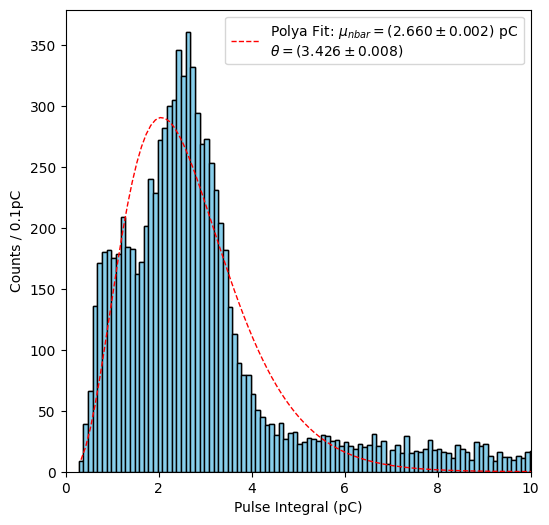

In [ ]:
#have a look at the data plots after cleaning!

#baseline mean and gaussian
plt.figure(figsize=(6,6))
mean_b_array_mV = cleaned_df['baseline'].to_numpy() * 1e3 

def gaussian_mb(x, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (x - mu)**2)/ sigma**2)

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.01) #chosen 1 bin = 0.01 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(gaussian_mb, bin_centers, n, p0=[np.max(n), np.mean(mean_b_array_mV), np.std(mean_b_array_mV)])
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
mu_mb = popt[1]
sigma_mb = popt[2]
mb_fit = gaussian_mb(bin_centers, *popt)
plt.plot(bin_centers, mb_fit, 'r--', linewidth=1)
plt.xlim(-1, 4)
plt.xlabel('Mean Baseline Values after cleaning (mV)')
plt.ylabel('Counts per milliVolt')
plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_mb, err_mu, sigma_mb, err_sigma)], loc='best', fontsize=10)
#plt.show()

# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))
sigma_b_array_mV = cleaned_df['sd_baseline'].to_numpy() * 1e3

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.01) #chosen 1 bin = 0.01mV
print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(gaussian_sb, bin_centers, n, p0=[np.max(n), np.mean(sigma_b_array_mV), np.std(sigma_b_array_mV)])
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
mu_sb = popt[1]
sigma_sb = popt[2]
sb_fit = gaussian_mb(bin_centers, *popt)
plt.plot(bin_centers, sb_fit, 'r--', linewidth=1)
plt.xlim(0, 5)
plt.xlabel('Baseline Standard Deviation after cleaning (mV)')
plt.ylabel('Counts / ')
plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_sb, err_mu, sigma_sb, err_sigma)], loc='best', fontsize=10)
#plt.show()


# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = cleaned_df['amplitude'].to_numpy() * 1e3
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,250)
plt.ylim(0,450)
plt.xlabel('Pulse Amplitudes after cleaning (mV)')
plt.ylabel('Counts per milliVolt')
#plt.show()

# histogram of Peak Times
plt.figure(figsize=(6, 6))
all_peak_times_ns = cleaned_df['peak_time'].to_numpy() * 1e9
pt_number_of_bins = int((np.max(all_peak_times_ns)-np.min(all_peak_times_ns))/0.001) #chosen 1 bin = 0.1ns
plt.hist(all_peak_times_ns, bins=pt_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-1,13)
plt.ylim(0,2000)
plt.xlabel('Position of Pulse Amplitude on Timebase after cleaning (ns)')
plt.ylabel('Counts per nanosecond')
#plt.show()

#to see extreme events
#for i, x in enumerate(all_peak_times_ns):
 #   if x < 0:
  #      print(i, x)
   # if x > 10:
    #    print(i, x)

# histogram for FWHM values
plt.figure(figsize=(6, 6))
all_FWHM_ns = cleaned_df['FWHM'].to_numpy() * 1e9
fwhm_number_of_bins = int((np.max(all_FWHM_ns)-np.min(all_FWHM_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_FWHM_ns, bins=fwhm_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,15)
plt.ylim(0,2000)
plt.xlabel('Pulse FWHM after cleaning (ns)')
plt.ylabel('Counts per nanosecond')
#plt.show()

#to see the tail events
#for i, x in enumerate(all_FWHM_ns):
    #if x > 4:
      #print(i, x)
#index doesnt really match original - best to check on both code before generating single pulses

# histogram for first crossings of 3sigma threshold
plt.figure(figsize=(6, 6))
filtered_crossings_ns = cleaned_df['first_threshold_crossing'].dropna().to_numpy() * 1e9
if len(filtered_crossings_ns) > 1:
    crosst_number_of_bins = int((np.max(filtered_crossings_ns) - np.min(filtered_crossings_ns)) / 0.1) #chosen 1 bin = 0.1ns
    plt.hist(filtered_crossings_ns, bins=crosst_number_of_bins, color='skyblue', edgecolor='black')
    plt.xlim(-20,50)
    plt.ylim(0,500)
    plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold after cleaning (ns)')
    plt.ylabel('Counts per nanosecond')
    #plt.show()
else:
    print("Cannot plot histogram: Fewer than two valid first crossing times found.")

#to see the tail events
#for i, x in enumerate(filtered_crossings_ns):
 #   if x < -3:
  #      print(i, x)
#index doesnt really match original - best to check on both code before generating single pulses


# histogram of pulse integrals in pC
plt.figure(figsize=(6, 6))
all_integrals_picocharge = cleaned_df['integral_pC'].to_numpy()
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-5, 100)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals after cleaning (pC)')
plt.ylabel('Counts / 0.1 pC')
#plt.show()

def polya_dist(all_integrals_picocharge, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A * (1/nbar)*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((all_integrals_picocharge/nbar)**theta)*np.exp(-(theta + 1)*(all_integrals_picocharge/nbar))
    return polya_PMF

Delta_x = 0.1 
int_number_of_bins = int((np.max(all_integrals_picocharge) - np.min(all_integrals_picocharge)) / Delta_x)
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

initial_nbar = np.mean(all_integrals_picocharge)
initial_var = np.var(all_integrals_picocharge) 
print(initial_nbar, initial_var)
N_events = len(all_integrals_picocharge)
initial_A = N_events * Delta_x
initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

p0 = [initial_A, initial_nbar, initial_theta]

popt, pcov = curve_fit(polya_dist, bin_centers, n , p0=p0, absolute_sigma=True, maxfev=10000)
A_fit, nbar_fit, theta_fit = popt
err_A = np.sqrt(pcov[0, 0])
err_nbar = np.sqrt(pcov[1, 1])
err_theta = np.sqrt(pcov[2, 2])
polya_dist_fit = polya_dist(bin_centers, *popt)

plt.plot(bin_centers, polya_dist_fit, 'r--', linewidth=1)
plt.xlim([0,10])
plt.xlabel('Pulse Integral (pC)')
plt.ylabel('Counts / 0.1pC')
plt.legend([
   r'Polya Fit: $\mu_{nbar}=(%.3f \pm %.3f)\ \mathrm{pC}$'
        '\n'
        r'$\theta=(%.3f \pm %.3f)$' % (
            nbar_fit, err_nbar,
            theta_fit, err_theta)], loc='best', fontsize=10)
#plt.show()


4.36232480445043 29.96354800215502


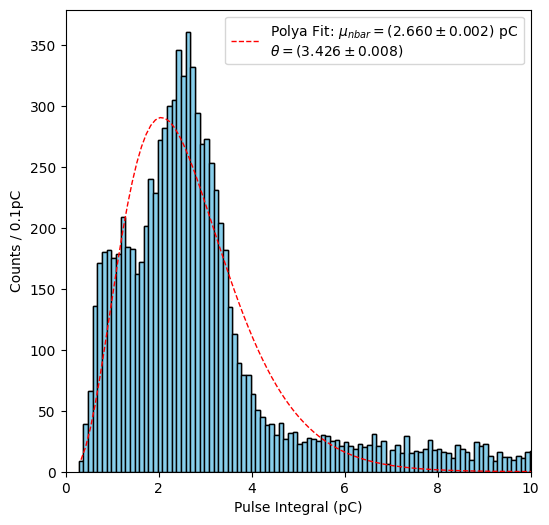

In [ ]:
plt.figure(figsize=(6, 6))
all_integrals_picocharge = cleaned_df['integral_pC'].to_numpy()
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-5, 100)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals after cleaning (pC)')
plt.ylabel('Counts / 0.1 pC')
#plt.show()

def polya_dist(all_integrals_picocharge, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A * (1/nbar)*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((all_integrals_picocharge/nbar)**theta)*np.exp(-(theta + 1)*(all_integrals_picocharge/nbar))
    return polya_PMF

Delta_x = 0.1 
int_number_of_bins = int((np.max(all_integrals_picocharge) - np.min(all_integrals_picocharge)) / Delta_x)
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

initial_nbar = np.mean(all_integrals_picocharge)
initial_var = np.var(all_integrals_picocharge) 
print(initial_nbar, initial_var)
N_events = len(all_integrals_picocharge)
initial_A = N_events * Delta_x
initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

p0 = [initial_A, initial_nbar, initial_theta]

popt, pcov = curve_fit(polya_dist, bin_centers, n , p0=p0, absolute_sigma=True, maxfev=10000)
A_fit, nbar_fit, theta_fit = popt
err_A = np.sqrt(pcov[0, 0])
err_nbar = np.sqrt(pcov[1, 1])
err_theta = np.sqrt(pcov[2, 2])
polya_dist_fit = polya_dist(bin_centers, *popt)

plt.plot(bin_centers, polya_dist_fit, 'r--', linewidth=1)
plt.xlim([0,10])
plt.xlabel('Pulse Integral (pC)')
plt.ylabel('Counts / 0.1pC')
plt.legend([
   r'Polya Fit: $\mu_{nbar}=(%.3f \pm %.3f)\ \mathrm{pC}$'
        '\n'
        r'$\theta=(%.3f \pm %.3f)$' % (
            nbar_fit, err_nbar,
            theta_fit, err_theta)], loc='best', fontsize=10)
#plt.show()

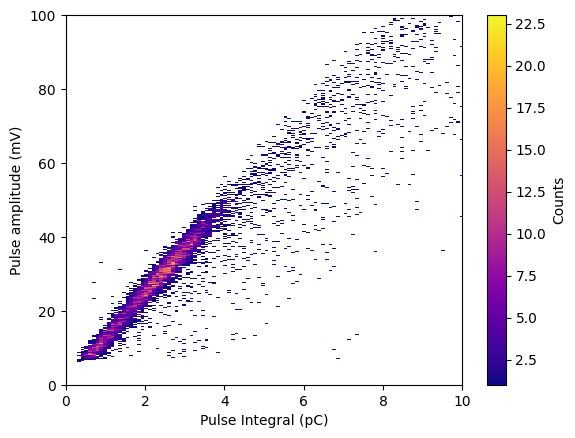

In [ ]:
amplitudes = cleaned_df['amplitude'] * 1e3
pulse_integrals = cleaned_df['integral_pC']

#plt.hist2d(pulse_integrals, amplitudes, bins=10, range=None, density=False)
h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',
    cmin=1,     # nicer color map
)
plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 10])
plt.ylim([0, 100])
#plt.ylim([np.min(amplitudes), 80])
plt.show()

In [ ]:
#export the cleaned data to another csv

#cleaned_df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=True, header=True)


In [ ]:
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 191
number of events in cleaned data frame: 9809
